# Collaborative filtering example

collab models use data in a DataFrame of user, items, and ratings.

In [0]:
from fastai.collab import *
from fastai.tabular import *

import warnings
warnings.filterwarnings('ignore')

# Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [0]:
user,item,title = 'userId','movieId','title'

In [3]:
import os
os.chdir('/content/')
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip *.zip

--2019-10-24 13:58:15--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  11.3MB/s    in 0.4s    

2019-10-24 13:58:15 (11.3 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [4]:
ratings = pd.read_csv('ml-100k/u.data', delimiter='\t', header=None, names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies = pd.read_csv('ml-100k/u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [6]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

By default the CollabDataBunch assumes that the 
* user details in 1st column
* item in 2nd column
* rating in 3rd column

Here we want to use 'title' column as the item, so mention it as 'item_name'.

In [8]:
data.show_batch()

userId,title,target
782,Broken English (1996),2.0
768,Ransom (1996),3.0
94,Dumbo (1941),4.0
567,Lost Horizon (1937),4.0
634,Heat (1995),3.0


In [9]:
#checking
rating_movie.loc[rating_movie.title=='Chasing Amy (1997)'][rating_movie.userId==521]

,userId,movieId,rating,timestamp,title
4816,521,246,4,884475913,Chasing Amy (1997)
22200,521,268,5,884475470,Chasing Amy (1997)


In [0]:
# This is last layer of the Neural Network with a sigmoid activation (ratings must be in b/w 0 to 5 - 5.5 is max limit here as data has more 5 rating movies)
y_range = [0,5.5]

In [0]:
# Latent factors is nothing but matrix embedding width, wd = weight decay
# n_factors = 10/20/40/80 - check and choose the best
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


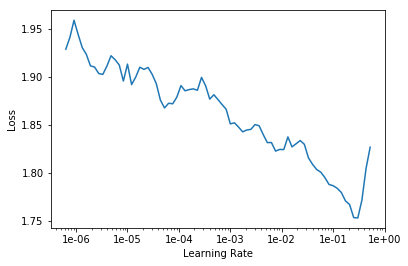

In [12]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [13]:
# We just use one learning rate instead of discriminative learning rate as we have only one layer in Collaberative Filtering
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.907645,0.948308,00:13
1,0.848787,0.886560,00:13
2,0.765081,0.836427,00:13
3,0.636527,0.816138,00:13
4,0.562048,0.814123,00:13


In [0]:
learn.save('dotprod')

Here's some [benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of 0.91**2 = 0.83.

### Interpretation

#### Setup

In [0]:
learn.load('dotprod');

In [16]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [17]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

#### Movie bias

> Get top movies using bias that the model learnt

In [18]:
# get bias using top_movies item
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
# sort based on 1st column which is bias (b) in movie_ratings
item0 = lambda o:o[0]

In [21]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3450),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3228), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3080),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3066), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2720), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2541), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2464), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2449), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2375), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2371), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2341), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2305), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2246), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2196), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2156), 'Leave It to Beaver (1997)', 1.84090909090909

In [22]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6180), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5602), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5521), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5441), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5372), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5321), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5257), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5194), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5051), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5036), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4918), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4874), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4702), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4689), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4670), 'Vertigo (1958)', 4.251396648044692)]

#### Movie weights

In [23]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [24]:
# squashing 40 latent factors to 3 using PCA, as most of the movies doesn't have more than 3 latent factors
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
# saving factors to individual variables
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [26]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1060), 'Close Shave, A (1995)'),
 (tensor(1.0676), 'Wrong Trousers, The (1993)'),
 (tensor(1.0438), 'Chinatown (1974)'),
 (tensor(1.0370), 'Casablanca (1942)'),
 (tensor(0.9884), 'Lawrence of Arabia (1962)'),
 (tensor(0.9627), 'Godfather, The (1972)'),
 (tensor(0.9616),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9442), 'Third Man, The (1949)'),
 (tensor(0.9414), 'Fargo (1996)'),
 (tensor(0.9288), 'Big Sleep, The (1946)')]

In [27]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2491), 'Home Alone 3 (1997)'),
 (tensor(-1.2097), 'Bio-Dome (1996)'),
 (tensor(-1.2049), "McHale's Navy (1997)"),
 (tensor(-1.1620), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1612), 'Leave It to Beaver (1997)'),
 (tensor(-1.1446), 'Congo (1995)'),
 (tensor(-1.1377), 'Jungle2Jungle (1997)'),
 (tensor(-1.1138), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0809), 'Richie Rich (1994)'),
 (tensor(-1.0694), 'Batman & Robin (1997)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [29]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2013), 'Braveheart (1995)'),
 (tensor(-1.0815), 'Titanic (1997)'),
 (tensor(-1.0017), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9119), 'Pretty Woman (1990)'),
 (tensor(-0.8843), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8771), 'Return of the Jedi (1983)'),
 (tensor(-0.8518), 'Forrest Gump (1994)'),
 (tensor(-0.8499), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8491), "It's a Wonderful Life (1946)"),
 (tensor(-0.8319), 'Sleepless in Seattle (1993)')]

In [30]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9035), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8165), 'Clockwork Orange, A (1971)'),
 (tensor(0.8086), 'Trainspotting (1996)'),
 (tensor(0.7929), 'Serial Mom (1994)'),
 (tensor(0.7913), 'Cable Guy, The (1996)'),
 (tensor(0.7826), 'Brazil (1985)'),
 (tensor(0.7819), 'Sweet Hereafter, The (1997)'),
 (tensor(0.7794), 'Dead Man (1995)'),
 (tensor(0.7761), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7568), 'Keys to Tulsa (1997)')]

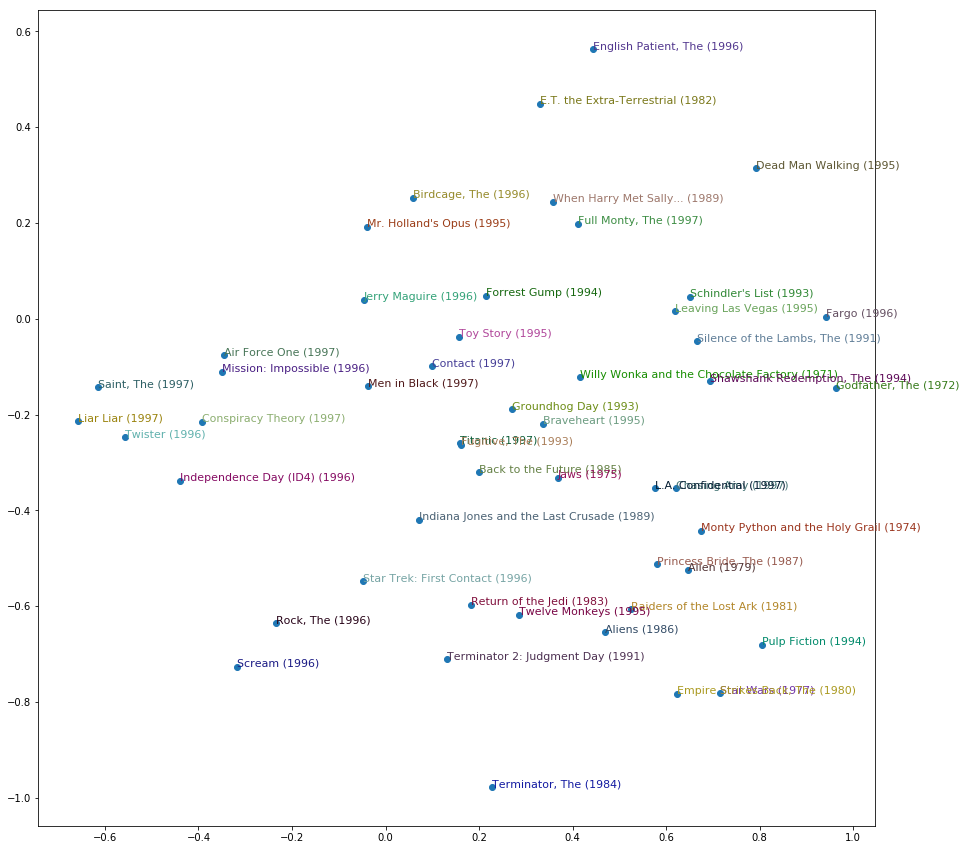

In [31]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()